# Explore the one_month_forecast_predict_delta_norm_y_latlons

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [3]:
!pip install xarray

     |████████████████████████████████| 736 kB 4.1 MB/s eta 0:00:01


In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')


assert data_dir.exists()

In [6]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

In [7]:
import numpy as np

def sample_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]


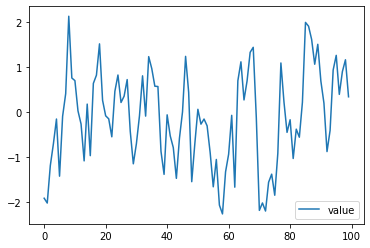

In [8]:
signal = sample_signal(100, 0.6)
d = pd.DataFrame({'value': signal}, index=np.arange(len(signal)))
d.plot()

In [9]:
d.loc[0:27].values.flatten()

array([-1.91565622, -2.02264848, -1.19177095, -0.70911903, -0.15884716,
       -1.42663848, -0.09714112,  0.40424404,  2.12137248,  0.75112904,
        0.69374143,  0.02134825, -0.26968895, -1.08714725,  0.17238815,
       -0.97143845,  0.63183982,  0.8135679 ,  1.508667  ,  0.25595291,
       -0.08704696, -0.15480498, -0.55309686,  0.45633706,  0.8174859 ,
        0.20858808,  0.34739225,  0.71631541])

In [10]:
data = d.loc[0:27]
data.index = pd.date_range('2000', periods=28, freq='M')
data.loc[pd.to_datetime('2002-05-31')] = -1.5
data = data.rename(columns={'value': 'VCI'})

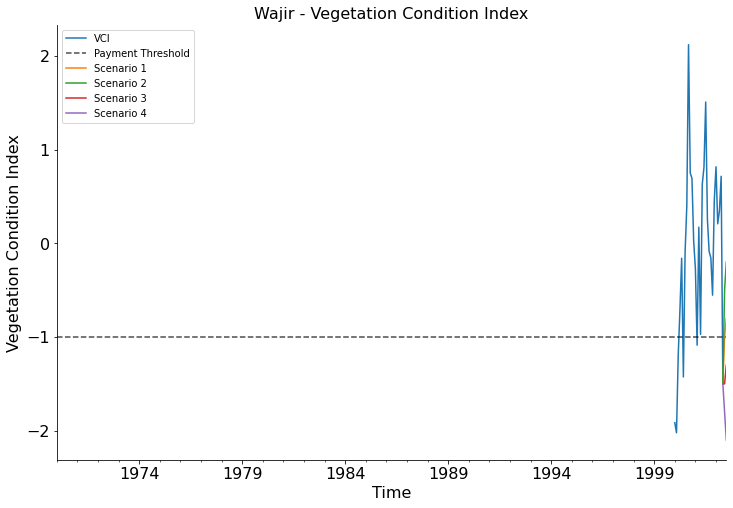

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
# (data).resample('D').interpolate()
data.plot(ax=ax)
ax.axhline(-1, color='k', ls='--', alpha=0.7, label='Payment Threshold')

ax.set_title('Wajir - Vegetation Condition Index')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper right', fontsize=14)
# ax.set_yticklabels(np.arange(0, 100, 10));
ax.set_ylabel('Vegetation Condition Index')
ax.set_xlabel('Time')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

pd.DataFrame({
    'Scenario 1': np.array([data.iloc[-1].values[0], -1.0, -0.8]),
    'Scenario 2': np.array([data.iloc[-1].values[0], -0.5, -0.2]),
    'Scenario 3': np.array([data.iloc[-1].values[0], -1.5, -1.3]),
    'Scenario 4': np.array([data.iloc[-1].values[0], -1.8, -2.1]),}, 
index=pd.date_range('2002-05-31', '2002-07-31', freq='M')).plot(ax=ax)

# Read in the data

In [16]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [28]:
!git pull

Auto-merging notebooks/draft/48_a_ML_model_errors.ipynb
CONFLICT (content): Merge conflict in notebooks/draft/48_a_ML_model_errors.ipynb
Auto-merging notebooks/draft/47_compare_to_FUSE.ipynb
CONFLICT (content): Merge conflict in notebooks/draft/47_compare_to_FUSE.ipynb
Automatic merge failed; fix conflicts and then commit the result.


In [24]:
data = xr.open_dataset("/home/jovyan/ml_drought/data/train_data.nc")
data = data.sortby("time")

In [ ]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [ ]:
ds

In [ ]:
mask = get_ds_mask(X_train.VCI)

In [ ]:
ealstm_pred = read_pred_data(
    'ealstm', data_dir, experiment='one_month_forecast_predict_delta_norm_y_latlons'
)[-1].where(~mask)

# Time Series of the Performance

In [ ]:
from src.analysis import annual_scores

In [ ]:
# load the monthly scores dictionary
experiment = 'one_month_forecast_predict_delta_norm_y_latlons'
true_data_experiment = 'one_month_forecast'
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['ealstm'],
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2011, 2019)],
    experiment=experiment,
    true_data_experiment=true_data_experiment,
    target_var='VCI',
    verbose=False,
    to_dataframe=True
)
monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
monthly_scores.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['ealstm']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .groupby('month').mean().reset_index()
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance')
ax.set_ylabel('RMSE');

# (
#     monthly_scores
#     .where(monthly_scores.metric == 'rmse')
#     .groupby('month').mean().reset_index()
#     .plot(x='month', y=model, label=model, ax=ax)
# )

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'ealstm_omf_static_embedding']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .set_index('time')
        .plot(y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Model Performance over time')
ax.set_ylabel('RMSE');


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test.VCI), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.VCI), ax=ax, label='train [1982-2010]')
# sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='Previous EALSTM')
sns.distplot(drop_nans_and_flatten(ealstm_best_pred), ax=ax, label='BEST EALSTM')

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted');

In [ ]:
v = ds.VCI.values
sns.distplot(v[~np.isnan(v)])

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ds.ndvi.where(~mask).mean(dim='time').plot(ax=ax, vmin=0)

print(ax.get_xlim())
print(ax.get_ylim())

In [ ]:
# from scripts.drafts.plotting_utils import plot_normalised_seasonality, plot_seasonality, plot_xarray_on_map
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
da = ds.VCI.sel(time='2017-04').squeeze(dim='time', drop=True)
title = 'VCI in April 2017'

da = ds.ndvi.where(~mask).mean(dim='time')
title = 'Mean NDVI Conditions [1981-2019]'
title = 'Mean Vegetation Health [1981-2019]'
# display(da);

# get the centre of the map
mid_lat = np.mean(da.lat.values)
mid_lon = np.mean(da.lon.values)

# make spatial plots
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    1, 1, 1, projection=cartopy.crs.Orthographic(mid_lon, mid_lat)
)

kwargs = {"vmin": 0, "vmax": None}
vmin = kwargs.pop("vmin", None)
vmax = kwargs.pop("vmax", None)

im = da.plot.pcolormesh(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax)
# cbar = plt.colorbar(im)

# set the xlim/ylim
ax.set_xlim((33.625, 42.375))
ax.set_ylim((-5.125, 6.125))

# set the title
ax.set_title(title, size='15')

# colorbar 
variable = da.name
variable = ''
cbar.set_label(label=variable.upper(), size='15') #, weight='bold')
cbar.ax.tick_params(labelsize='15')

# add the extra assets from cartopy
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)

# turn off the axes outline
ax.outline_patch.set_visible(False)

# print(ax.get_xlim())
# print(ax.get_ylim())
# fig.savefig(f'/Users/tommylees/Downloads/{variable.upper}_spatial_plot.png')

# Explore performance in different regions